# Regrid atmospheric data

## TODO

- [x] Increase worker memory. This works yay!
    - [x] Find minimum memory needed to run this. **16** works. 8 seems low, but 32 might be necessary to not rechunk the data.
    - [x] Write out a part of the dataset?
- [x] Store the weigthts as zarr in pangeo scratch (later work with charles to set up an automated way to do that?)
- [x] sketch up a filtered temp difference between ocean + atmosphere
- [x] Use .coarsen() instead of gcm-filters. Massive increase in performance!
- [ ] Package this into a reproducible data pipeline.
    - [ ] Pangeo-forge recipe to bring the weights into the cloud
    - [ ] Process this with coiled workers?
- [ ] Coarsening
    - [ ] How do we deal with boundaries? Right now I am padding with 0 and the coasts are influencing the values.
- Aerobulk
    - Masking issues: Make an issue
- The execution is only using 1 core. Does it speed up things to make this threadsafe?
    
## Refactor TODO:
- [ ] Permanent store of the regridder data, not on scratch. Where should we put that?

In [2]:
# Eventually we want this on the pangeo image, but for now install manually
# !mamba install aerobulk-python -y

In [3]:
## manually recreate the wrapper.
import xarray as xr
from aerobulk import flux_skin, flux_noskin
import matplotlib.pyplot as plt
# def _check_shape(arr):
#     if arr.ndim != 3:
#         raise ValueError


def flux_noskin_xr(
    sst, t_zt, hum_zt, u_zu, v_zu, slp=101000.0, algo="coare3p0", zt=10, zu=2, niter=1
):
    # TODO do we need to make the "time" dimension special?

    sst, t_zt, hum_zt, u_zu, v_zu, slp = xr.broadcast(
        sst, t_zt, hum_zt, u_zu, v_zu, slp
    )

    if len(sst.dims) < 3:
        # TODO promote using expand_dims?
        raise NotImplementedError
    if len(sst.dims) > 4:
        # TODO iterate over extra dims? Or reshape?
        raise NotImplementedError

    out_vars = xr.apply_ufunc(
        flux_noskin,
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp,
        input_core_dims=[()] * 6,
        output_core_dims=[()] * 5,
        # input_core_dims=[("dim_0", "dim_1", "dim_2")] * 6,
        # output_core_dims=[("dim_0", "dim_1", "dim_2")] * 5,
        dask="parallelized",
        kwargs=dict(
            algo=algo,
            zt=zt,
            zu=zu,
            niter=niter,
        ),
        output_dtypes=[sst.dtype]
        * 5,  # deactivates the 1 element check which aerobulk does not like
    )

    if not isinstance(out_vars, tuple) or len(out_vars) != 5:
        raise TypeError("F2Py returned unexpected types")

    if any(var.ndim != 3 for var in out_vars):
        raise ValueError(
            f"f2py returned result of unexpected shape. Got {[var.shape for var in out_vars]}"
        )

    # TODO if dimensions promoted squeeze them out before returning

    return out_vars  # currently returns only 3D arrays

def flux_skin_xr(
    sst, t_zt, hum_zt, u_zu, v_zu, rad_sw, rad_lw, slp=101000.0, algo="coare3p0", zt=10, zu=2, niter=1
):
    # TODO do we need to make the "time" dimension special?

    sst, t_zt, hum_zt, u_zu, v_zu, slp = xr.broadcast(
        sst, t_zt, hum_zt, u_zu, v_zu, slp
    )

    if len(sst.dims) < 3:
        # TODO promote using expand_dims?
        raise NotImplementedError
    if len(sst.dims) > 4:
        # TODO iterate over extra dims? Or reshape?
        raise NotImplementedError

    out_vars = xr.apply_ufunc(
        flux_skin,
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        rad_sw,
        rad_lw,
        slp,
        input_core_dims=[()] * 8,
        output_core_dims=[()] * 6,
        dask="parallelized",
        kwargs=dict(
            algo=algo,
            zt=zt,
            zu=zu,
            niter=niter,
        ),
        output_dtypes=[sst.dtype]
        * 6,  # deactivates the 1 element check which aerobulk does not like
    )

    if not isinstance(out_vars, tuple) or len(out_vars) != 6:
        raise TypeError("F2Py returned unexpected types")

    if any(var.ndim != 3 for var in out_vars):
        raise ValueError(
            f"f2py returned result of unexpected shape. Got {[var.shape for var in out_vars]}"
        )

    # TODO if dimensions promoted squeeze them out before returning

    return out_vars  # currently returns only 3D arrays

In [4]:
# These are all already in https://github.com/xgcm/aerobulk-python/pull/15


# ## see if the tests run here
# """Tests for the xarray wrapper"""
# from typing import Dict

# import numpy as np
# import pytest
# import xarray as xr


# def create_data(shape: tuple, chunks: Dict[str, int] = {}):
#     def _arr(value):
#         order = "F"  # Does this matter for the results?
#         arr = xr.DataArray(np.full(shape, value, order=order))

#         # adds random noise scaled by a percentage of the value
#         randomize_factor = 0.001
#         randomize_range = value * randomize_factor
#         arr = arr + np.random.rand(*shape) + randomize_range

#         if chunks:
#             arr = arr.chunk(chunks)
#         return arr

#     sst = _arr(290.0)
#     t_zt = _arr(280.0)
#     hum_zt = _arr(0.001)
#     u_zu = _arr(1.0)
#     v_zu = _arr(-1.0)
#     slp = _arr(101000.0)
#     return sst, t_zt, hum_zt, u_zu, v_zu, slp


# def test_chunked():
#     chunks = {"dim_2": 10}
#     shape = (50, 50, 20)
#     args = create_data(shape)
#     out_vars_chunked = flux_noskin_xr(*args)
#     out_vars_nochunks = flux_noskin_xr(*(a.load() for a in args))

#     for out_chunk, out_nochunk in zip(out_vars_chunked, out_vars_nochunks):
#         assert out_chunk.shape == shape
#         xr.testing.assert_allclose(out_chunk, out_nochunk)


# def test_transpose_invariance():
#     chunks = {"dim_2": 10}
#     shape = (50, 50, 20)
#     args = create_data(shape)
#     out_vars_012 = flux_noskin_xr(
#         *(a.transpose("dim_0", "dim_1", "dim_2") for a in args)
#     )
#     out_vars_210 = flux_noskin_xr(
#         *(a.transpose("dim_2", "dim_1", "dim_0") for a in args)
#     )
#     out_vars_120 = flux_noskin_xr(
#         *(a.transpose("dim_1", "dim_2", "dim_0") for a in args)
#     )

#     for i, ii, iii in zip(out_vars_012, out_vars_120, out_vars_210):
#         xr.testing.assert_allclose(
#             i.transpose("dim_0", "dim_1", "dim_2"),
#             ii.transpose("dim_0", "dim_1", "dim_2"),
#         )
#         xr.testing.assert_allclose(
#             ii.transpose("dim_0", "dim_1", "dim_2"),
#             iii.transpose("dim_0", "dim_1", "dim_2"),
#         )
        
        
# test_transpose_invariance()

## Get some **beastmode** workers (with aerobulk installed if possible)

In [5]:
# import subprocess
# import logging
# from distributed import WorkerPlugin

# class MambaPlugin(WorkerPlugin):
#     """
#     Install packages on a worker as it starts up.

#     Parameters
#     ----------
#     packages : List[str]
#         A list of packages to install with pip on startup.
#     """
#     def __init__(self, packages):
#         self.packages = packages

#     def setup(self, worker):
#         logger = logging.getLogger("distributed.worker")
#         subprocess.call(['mamba', 'install'] + self.packages + ['-y'])
#         logger.info("Installed %s", self.packages)

In [6]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # make sure all the clusters are closed (This is expensive!)
# clusters = gateway.list_clusters()
# for cluster in clusters:
#     gateway.stop_cluster(cluster.name)

# options = gateway.cluster_options()

# # # set the options programatically, or through their HTML repr
# # options.worker_memory = 16  # 10 GB of memory per worker.

# # # Create a cluster with those options
# cluster = gateway.new_cluster(options, shutdown_on_close=True)
# client = cluster.get_client()

# # plugin = MambaPlugin(['aerobulk-python'])# this does not work apparently...
# # client.register_worker_plugin(plugin)

# cluster.scale(8)
# # cluster.adapt(4,40)
# cluster.scale(2)
# client

In [7]:
# import dask
# from dask.distributed import LocalCluster, Client
# dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})
# cluster = LocalCluster()
# client = Client(cluster)
# client

In [8]:
# def check():
#     import aerobulk
#     return aerobulk.mod_aerobulk_wrap.__version__
# client.run(check)

In [4]:
# load the ocean data
import fsspec
import xarray as xr
import xesmf as xe
import os
from intake import open_catalog
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)

# # for testing, rechunk everything to single time steps
# ds_ocean = ds_ocean.chunk({'time':1})
# ds_atmos = ds_atmos.chunk({'time':1})
# ds_flux = ds_flux.chunk({'time':1})

## Visualize some fields

In [5]:
# import hvplot.xarray

In [6]:
# ds_flux

In [7]:
# ds_flux

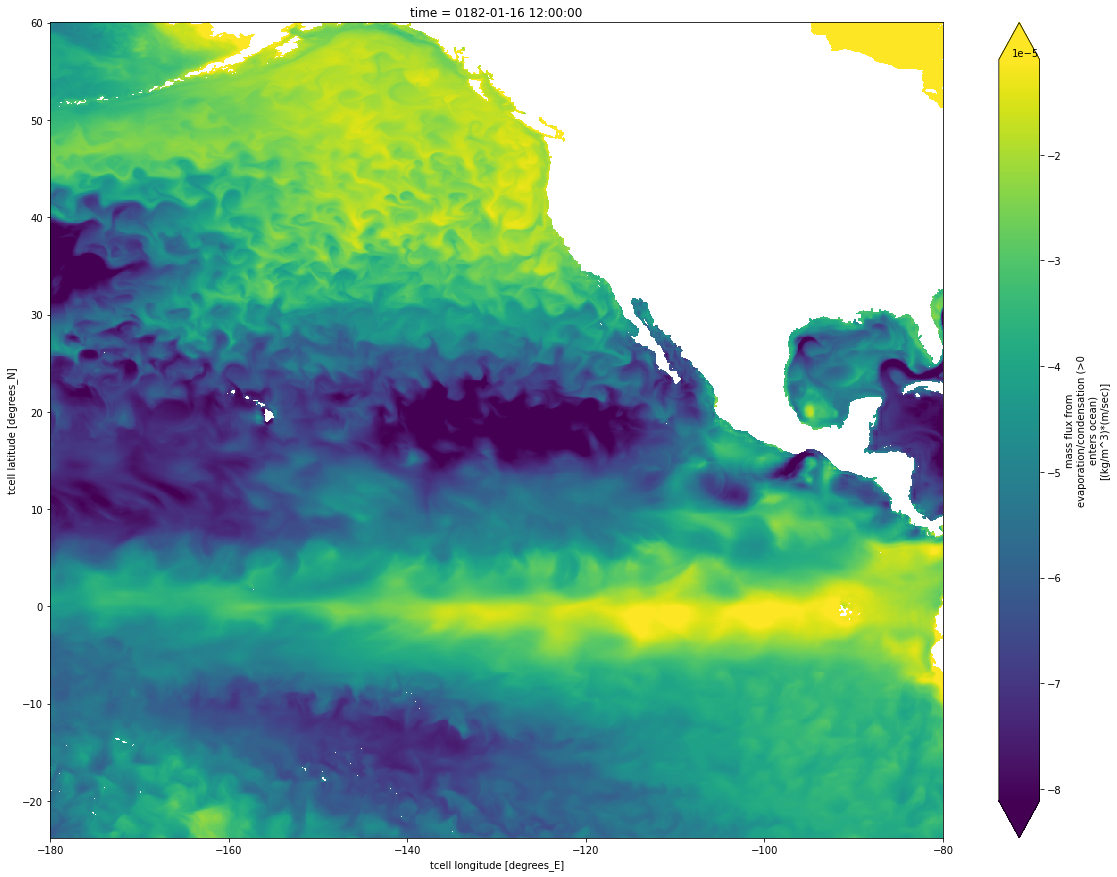

In [23]:
plt.figure(figsize=[20, 15])
ds_flux.unify_chunks().evap.isel(time=12, xt_ocean=slice(1000, 2000), yt_ocean=slice(1000, 2000)).plot(robust=True)

In [8]:
# cat["GFDL_CM2_6_control_ocean"].to_dask().time_bounds.load()

In [15]:
import json
import gcsfs

# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr'
mapper = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper)
regridder = xe.Regridder(
    ds_atmos.olr.to_dataset(name='dummy').isel(time=0),
    ds_ocean.surface_temp.to_dataset(name='dummy').isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [10]:
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']
# From `upload_cm26_weights_from_gyre.ipynb`
mapper = fsspec.get_mapper(f'{PANGEO_SCRATCH}/jbusecke/test_cm26_xesmf_weights_cloud.zarr')
ds_regridder = xr.open_zarr(mapper)#.persist()

regridder = xe.Regridder(
    ds_atmos.olr.isel(time=0),
    ds_ocean.surface_temp.isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [ ]:
flux_skin(

In [18]:
ds_atmos.lwdn_sfc

<xarray.Dataset>
Dimensions:       (time: 7305, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [19]:
ds_atmos_regridded = regridder(ds_atmos[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref', 'swdn_sfc', 'lwdn_sfc']])
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean[['surface_temp']],
    ]
)
ds_merged

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swdn_sfc      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    lwdn_sfc      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## First aerobulk test (TODO: Turn into issue)
Test the execution time based on dim permutations

In [20]:
subset_ROI = dict(
    yt_ocean=slice(1400, 2000),
    xt_ocean=slice(2200, 2500)
)

In [13]:
ds_test = ds_merged.isel(
    time=slice(0,31),**subset_ROI
)
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds_test = ds_test.load()

# transpose the dataset
import time
execution_time = {}
results = {}

for transpose_dims in [
    ('xt_ocean', 'yt_ocean', 'time'),
    ('yt_ocean', 'xt_ocean', 'time'),
    ('time', 'xt_ocean', 'yt_ocean'),
    ('yt_ocean', 'time', 'xt_ocean'),
]:
    ds_test = ds_test.transpose(*transpose_dims)

    # Convert units. If we dont this just crashes due to the missing error handling currently (https://github.com/xgcm/aerobulk-python/issues/4)
    # TODO: the attrs are missing on the merged dataset. Investigate why. Need those for pint later.
    sst = ds_test.surface_temp + 273.15
    t_zt = ds_test.t_ref
    hum_zt = ds_test.q_ref
    u_zu = ds_test.u_ref
    v_zu = ds_test.v_ref
    slp = ds_test.slp * 100 # check this

    niter=2# was 15 before
    zt = 10.0
    zu = 2.0
    calgo = "coare3p0"
    tic = time.time()
    ql, qh, tau_x, tau_y, evap = flux_noskin_xr(sst, t_zt, hum_zt, u_zu, v_zu, slp)
    elapsed_time = time.time()-tic
    execution_time[transpose_dims] = elapsed_time
    results[transpose_dims] = (ql, qh, tau_x, tau_y, evap)

[########################################] | 100% Completed |  1min 26.1s
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00300 x 00600
     *** Number of time records that will be treated:          31
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00600 x 00300
     *** Number of time records that will be treated:          31
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `m

In [14]:
execution_time

{('xt_ocean', 'yt_ocean', 'time'): 11.423014640808105,
 ('yt_ocean', 'xt_ocean', 'time'): 11.417233228683472}

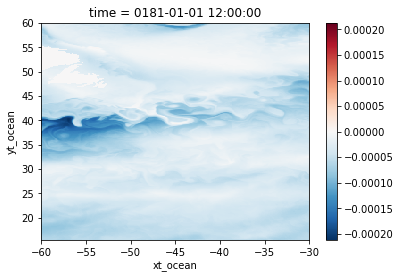

In [15]:
evap.isel(time=0).plot()

## Sanity check: How close can we get with aerobulk to the model internal flux

In [28]:
ds_test = ds_merged.isel(time=slice(0,31), xt_ocean=slice(1000, 2000)).transpose('yt_ocean', 'xt_ocean', 'time')

In [29]:
ds_test

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 1000, time: 31)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean      (xt_ocean) float64 -179.9 -179.8 -179.7 ... -80.15 -80.05
  * time          (time) object 0181-01-01 12:00:00 ... 0181-01-31 12:00:00
Data variables:
    slp           (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    swdn_sfc      (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    lwdn_sfc      (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean, time) float32 dask.array<chunksize=(2700, 1000, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [30]:
# Convert units. If we dont this just crashes due to the missing error handling currently (https://github.com/xgcm/aerobulk-python/issues/4)
# TODO: the attrs are missing on the merged dataset. Investigate why. Need those for pint later.
sst = ds_test.surface_temp + 273.15
t_zt = ds_test.t_ref
hum_zt = ds_test.q_ref
u_zu = ds_test.u_ref
v_zu = ds_test.v_ref
slp = ds_test.slp * 100 # check this
rad_sw = ds_test.swdn_sfc
rad_lw = ds_test.lwdn_sfc

niter=4# was 15 before
zt = 10.0
zu = 2.0
# calgo = "coare3p0" # about 25% error for CM2.6!!!
calgo = "ecmwf" # about 25% error for CM2.6!!!

ql, qh, tau_x, tau_y, t_s, evap = flux_skin_xr(
    sst,
    t_zt,
    hum_zt,
    u_zu,
    v_zu,
    rad_sw,
    rad_lw,
    slp,
    algo=calgo,
    niter=niter
)

In [31]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ql_recomputed = ql.mean('time').load()
    qh_recomputed = qh.mean('time').load()
    evap_recomputed = evap.mean('time').load()

[##                                      ] | 6% Completed | 32.5s 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
     *** Computational domain shape: Ni x Nj = 02700 x 01000
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    4
     *** Filling the `mask` array...
         ==> number of points to mask:        24857  (out of      2700000 )
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 
[###############################         ] | 77% Completed |  2min 29.6s 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
     *** Computational domain shape: Ni x Nj = 02700 x 01000
     *** Number of time records that will be

IOStream.flush timed out


 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
     *** Computational domain shape: Ni x Nj = 02700 x 01000
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    4
     *** Filling the `mask` array...
[####################################### ] | 99% Completed | 15min 13.2s         ==> number of points to mask:        21963  (out of      2700000 )
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 
[########################################] | 100% Completed | 15min 13.7s
[##                                      ] | 6% Completed |  6.7s 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
[##                            

IOStream.flush timed out


[#####################################   ] | 94% Completed |  9min 55.4s 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
     *** Computational domain shape: Ni x Nj = 02700 x 01000
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    4
     *** Filling the `mask` array...
         ==> number of points to mask:        22490  (out of      2700000 )
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 
[#####################################   ] | 94% Completed |  9min 55.5s 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
        ==> will use the Cool-skin & Warm-ayer scheme of `ecmwf` !
[######################################  ] | 95% Completed | 10min 21.3s     *** Computational dom

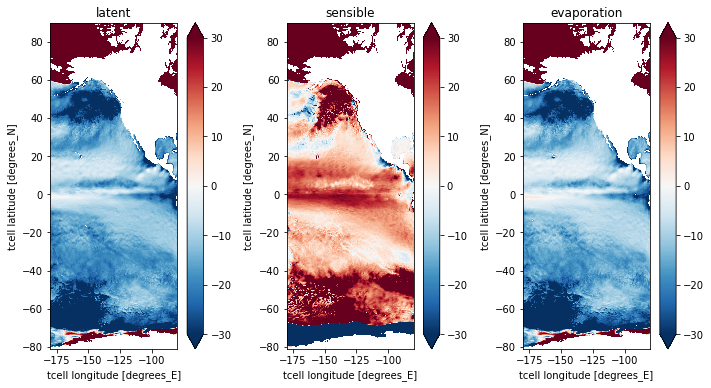

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
fig, axarr = plt.subplots(ncols=3, figsize=[12, 6])

for ax, (name, var, var_recomputed) in zip(axarr.flat, [
    ('latent', ql_recomputed, ds_flux.evap_heat.isel(time=0)),
    ('sensible', qh_recomputed, ds_flux.sens_heat.isel(time=0)),
    ('evaporation', evap_recomputed, ds_flux.evap.isel(time=0)),
]):
    plt.figure()
    difference = (var_recomputed-var)/abs(var)*100
    difference.plot(ax = ax, vmax=30)
    ax.set_title(name)
    ax.set_aspect(1.5)

In [49]:
ds_flux

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
  * xt_ocean                   (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yt_ocean                   (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * yu_ocean                   (yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [15]:
recalculated = test.mean('time')
raw = ds_flux.evap_heat.isel(time=0)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


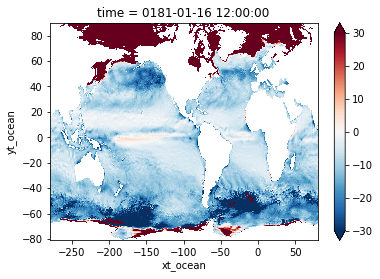

In [16]:
difference = (recalculated-raw)/raw*100
difference.plot(vmax=30)

In [11]:
ql_first_month = ql.mean('time').load()

2022-04-25 19:21:15,298 - distributed.protocol.pickle - INFO - Failed to serialize (<function getitem at 0x7efb40748670>, (subgraph_callable-9379ab91-7832-4e4a-a824-1403179315de, "('array-cd7ede6dc5ff5c5eb493c617f467f0f9',)", "('array-856e352cc6152061334a555e568bc0bb',)", "('array-64c273d59e5c548f4ae9a07f47cb3fea',)", (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-99949258fe3fbedee7763a895ae928e7', 22, 0, 0)"]], [1, 2]), (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-68f87a08c1411d575c621e5b8dd3cfd3', 22, 0, 0)"]], [1, 2]), (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-1011212a830de84c5c4deed7baf459d8', 22, 0, 0)"]], [1, 2]), (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-60953b928dfccbf6959d663a3a8cb0c6', 22, 0, 0)"]], [1, 2]), (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-50d46d9398ce7fadbc5b417449c7a957', 22, 0, 0)"]], [1, 2]), (<function concatenate_axes at 0x7efb36159e50>, [["('transpose-230af78d4c1f

CancelledError: ('mean_agg-aggregate-af25bd460dd039f8f7bfb5a84a16ec03', 0, 0)

In [ ]:
(ql_first_month.squeeze()-ds_flux['evap_heat'].isel(time=0)).plot(x='xt_ocean', robust=True)

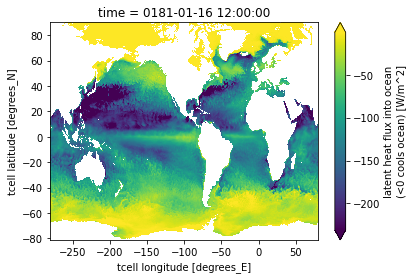

In [58]:
ds_flux['evap_heat'].isel(time=0).plot(x='xt_ocean', robust=True)

AttributeError: 'QuadMesh' object has no property 'col_break'

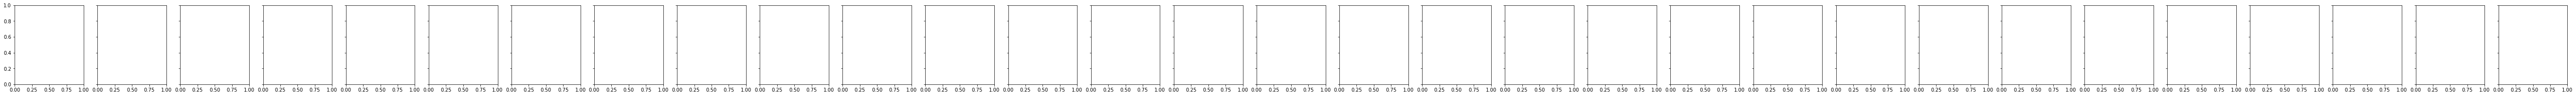

In [40]:
ds_merged.evap.isel(time=slice(0,31)).plot(col='time', col_wrap=6)

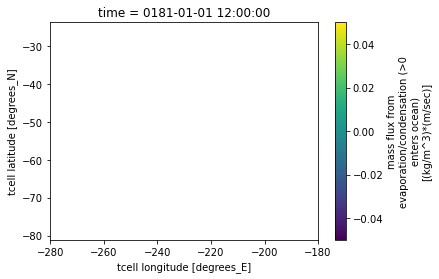

In [37]:
ds_test.evap.plot()

## Now filter everything !!! Going the Coarsen round for now !!!

In [16]:

# dxu = ds_oc_grid.dxu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})
# dyu = ds_oc_grid.dyu.swap_dims({"xu_ocean": "xt_ocean","yu_ocean": "yt_ocean"})
# # Find the minimum grid spacing
# dx_min = min(ds_oc_grid.dxt.where(ds_oc_grid.wet).min(), ds_oc_grid.dyt.where(ds_oc_grid.wet).min())
# dx_min = dx_min.values
# dx_min

In [17]:
# import gcm_filters
# specs = {
#     'filter_scale': 100000, # 100km in m
#     'dx_min': dx_min,
#     'filter_shape': gcm_filters.FilterShape.GAUSSIAN
# }

# filter_MOM5T = gcm_filters.Filter(
#     **specs,
#     grid_type = gcm_filters.GridType.MOM5T,
#     grid_vars = {'wet_mask':ds_oc_grid.wet,'dxt':ds_oc_grid.dxt,'dyt':ds_oc_grid.dyt,
#                  'dxu':dxu,'dyu':dyu,'area_t':ds_oc_grid.area_t}
# )
# filter_MOM5T

In [18]:
# # Apply the filter
# ds_merged_filtered = filter_MOM5T.apply(ds_merged, dims=['yt_ocean','xt_ocean'])

In [21]:
test = ds_merged.coar

In [29]:
# simpler alternative with coarsen
weights = ds_oc_grid['area_t'].where(ds_oc_grid.wet)#.fillna(0)
coarsen_kwargs = dict(xt_ocean=20, yt_ocean=20)

def weighted_mean_coarsen(ds, weights, coarsen_kwargs):
    data_weighted = ds * weights
    data_coarsened = data_weighted.coarsen(coarsen_kwargs).sum()
    weights_coarsened = weights.coarsen(coarsen_kwargs).sum()
    
    return data_coarsened/weights_coarsened

ds_merged_coarsened = weighted_mean_coarsen(ds_merged, weights, coarsen_kwargs)
ds_flux_coarsened = weighted_mean_coarsen(ds_flux, weights, coarsen_kwargs)

/tmp/ipykernel_2397/3439791423.py:7: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  data_coarsened = data_weighted.coarsen(coarsen_kwargs).sum()
/tmp/ipykernel_2397/3439791423.py:7: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_ch

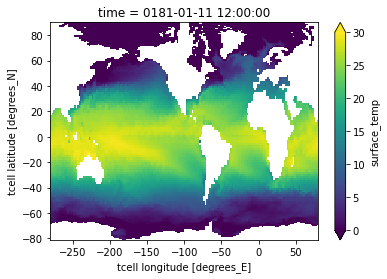

In [30]:
test_plot = ds_merged_coarsened.surface_temp.isel(time=10).compute()
test_plot.plot(vmin=0, vmax=30)

## Simulate an air sea algo

In [31]:
def dummy_flux(sst, air_temp, u, v, slp):
    return (air_temp-sst)*(u**2+v**2)**0.5/slp

In [34]:
# # worst case scenario (filtering on all variables)
flux = dummy_flux(
    ds_merged_coarsened.surface_temp,
    ds_merged_coarsened.t_ref,
    ds_merged_coarsened.u_ref,
    ds_merged_coarsened.v_ref,
    ds_merged_coarsened.slp
)
flux

<xarray.DataArray (time: 7305, yt_ocean: 135, xt_ocean: 180)>
dask.array<truediv, shape=(7305, 135, 180), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -80.71 -79.86 -79.02 ... 87.89 88.73 89.58
  * xt_ocean  (xt_ocean) float64 -279.0 -277.0 -275.0 -273.0 ... 75.0 77.0 79.0
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(135, 180), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(135, 180), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(135, 180), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(135, 180), meta=np.ndarray>

In [35]:
flux.isel(time=0).plot(robust=True)

KilledWorker: ("('mul-reshape-sum-sum-aggregate-1d957515f981e3c9b1984df81c9cc1a9', 0, 0, 0)", <WorkerState 'tls://10.8.35.6:36895', name: dask-worker-dc997563a27442029394c2f5cb39159e-s8rkt, status: closed, memory: 0, processing: 2>)

## Save out the results to see if this works completely lazily

In [43]:
# mapper = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_regridding/regridded_filtered_dummy_flux.zarr')

In [ ]:
# flux.to_dataset(name='test_flux').to_zarr(mapper, mode='w')

## Try adding a time aggregation on top!

In [ ]:
flux_monthly = flux.resample(time='1MS').mean()
flux_monthly

In [ ]:
# add the 'real flux'
flux_monthly['groundtruth']

In [21]:
mapper_monthly = fsspec.get_mapper(f'{PANGEO_SCRATCH}/test_regridding/regridded_filtered_dummy_flux_monthly.zarr')
flux_monthly.to_dataset(name='test_flux').isel(time=slice(0,24)).to_zarr(mapper_monthly, mode='w')

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## Notes
- seems like the scattering has not worked. Need to look into that in more detail.
- The chunks are not aligned. Need to figure out the best way how to do this.

## Read the dummy data back and average in time

In [42]:
test = xr.open_zarr(mapper)
test

<xarray.Dataset>
Dimensions:    (time: 24, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0181-01-24 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    test_flux  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

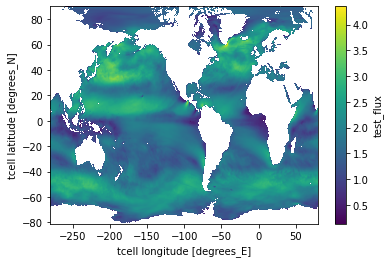

In [43]:
test.test_flux.mean('time').plot()